In [1]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import warnings
warnings.filterwarnings("ignore")

from models import matting_net

def convert_checkpoint_into_tflite(h5_path=None,
                                   output_path=None,
                                   android=True):
    if android:
        model = matting_net((256,256,4), android=True)
        
    else:
        model = matting_net((256,256,3), android=False)
    # model 명 과 상세사항 정리해두기 
    model.load_weights(h5_path, by_name=True)

    input_names = [node.op.name for node in model.inputs]
    output_names = [node.op.name for node in model.outputs]
    print(input_names)
    print(output_names)

    sess = K.get_session()
    converter = tf.lite.TFLiteConverter.from_session(sess, model.inputs, model.outputs)

    tflite_model = converter.convert()
    open(output_path, "wb").write(tflite_model)
    print("tflite successfully built")
    
    return model

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
tf.__version__

'1.14.0'

In [3]:
model = convert_checkpoint_into_tflite(h5_path="./trained_models/20191212/10.h5",
                                       output_path="./tflite/20191212_10.tflite", 
                                       android=True)

['input_1']
['output/Sigmoid']
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 166 variables.
INFO:tensorflow:Converted 166 variables to const ops.
tflite successfully built


## Model output test

In [4]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREaAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:]
img = img / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

pred = model.predict(img)

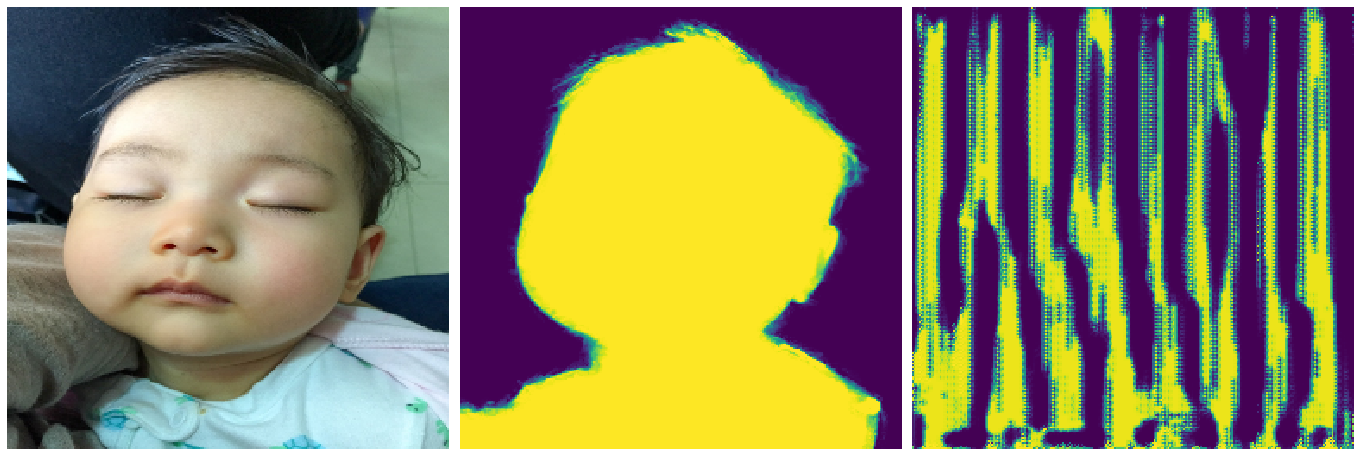

In [5]:
plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(132)
plt.imshow(mask)
plt.axis("off")

plt.subplot(133)
plt.imshow(pred.squeeze(0).squeeze(-1) * 255)
plt.axis("off")

plt.tight_layout()
plt.show()

### Model Output test 2

In [6]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X &amp; Y|)/ (|X or Y|)
    """
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    intersection = np.sum(np.abs(y_true * y_pred), axis=-1)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    
#     union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
iou_coef(mask[np.newaxis, :, :, np.newaxis], pred)

array([[[1.00662845e-07, 1.00662845e-07, 1.00662845e-07, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07],
        [1.00662845e-07, 1.00662845e-07, 1.00662845e-07, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07],
        [1.00662845e-07, 1.00662845e-07, 1.00662845e-07, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07],
        ...,
        [1.09813232e-06, 2.91105107e-06, 5.21240565e-07, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07],
        [2.00810809e-05, 3.76063895e-06, 1.11920724e-06, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07],
        [1.83492775e-05, 2.24589166e-06, 1.12836722e-06, ...,
         1.00662845e-07, 1.00662845e-07, 1.00662845e-07]]], dtype=float32)

In [8]:
from sklearn.metrics import confusion_matrix  

def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [26]:
mask_ = cv2.threshold(mask, 255/2, 255, cv2.THRESH_BINARY)
pred_ = cv2.threshold(pred.squeeze(0).squeeze(-1), 0.5, 1, cv2.THRESH_BINARY)
compute_iou(mask_[1], pred_[1])

0.3087817106937065

In [10]:
import numpy as np
from sklearn.metrics import log_loss

def cross_entropy(y_true, y_pred):
#     y_true = y_true.flatten()
#     y_pred = y_pred.flatten()
    
    N = y_pred.shape[0]# * y_pred.shape[1]
    
    ce = -np.sum(y_true*np.log(y_pred + 1e-5)) / N
    
    return ce


ce = cross_entropy(mask, pred.squeeze(0).squeeze(-1))

ce

123307.171875

In [39]:
mask_[1].shape

(256, 256)

In [11]:
mask, pred_

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]], dtype=uint8),
 (0.5, array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 1., 0.],
         [1., 0., 0., ..., 1., 1., 0.],
         [1., 0., 0., ..., 1., 1., 0.]], dtype=float32)))

In [12]:
train_params = {
            'dim': (256,256),
            'batch_size': 32,
            'n_channels': 3,
            'shuffle': True,
            'augment': True,
        }

In [13]:
img_paths = np.load("./dataset/selfie/img_paths.npy")

train_img_paths = np.random.choice(img_paths, int(img_paths.shape[0] * 0.8), replace=False)

test_img_paths = np.setdiff1d(img_paths, train_img_paths)

In [14]:
from data_generator import DataGeneratorMatting
train_gen = DataGeneratorMatting(train_img_paths, **train_params)

In [15]:
preds = model.predict(np.concatenate((train_gen[0][0], np.ones((32, 256, 256, 1))), axis=-1))

In [16]:
preds.shape

(32, 256, 256, 1)

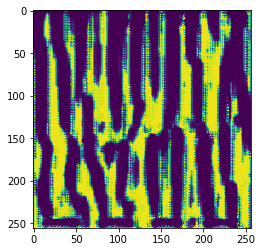

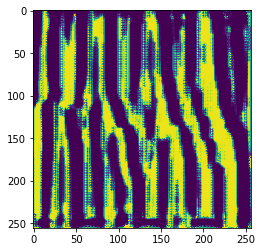

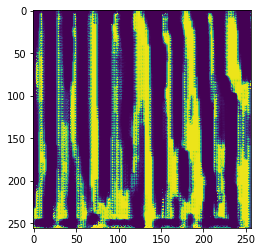

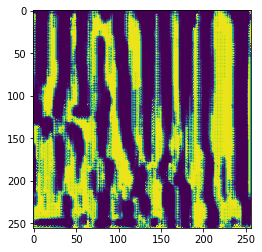

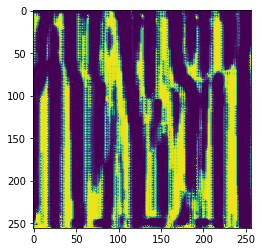

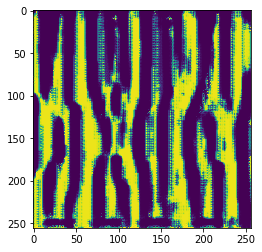

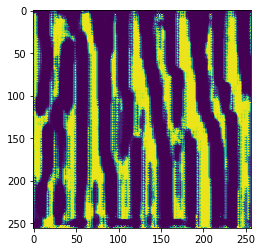

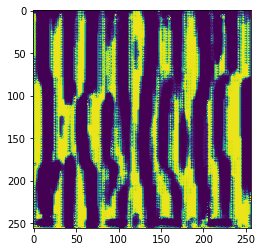

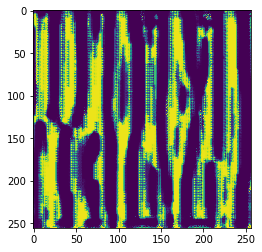

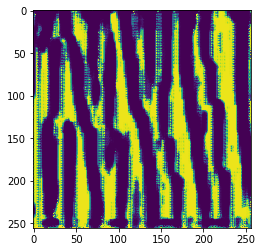

In [17]:
for pr in preds[10:20]:
    plt.imshow(pr.squeeze(-1))
    plt.show()

In [18]:
train_gen[0][1].shape

(32, 256, 256, 1)

In [19]:
preds.shape

(32, 256, 256, 1)

In [20]:
preds[0].flatten().shape

(65536,)

In [21]:
list(map(lambda x: cross_entropy(x[0], x[1]), zip(train_gen[0][1], preds)))

[672.4016230798312,
 752.5902371725762,
 471.08102909781246,
 560.7874868556488,
 489.2825937612238,
 582.0749647299408,
 900.5174585992845,
 524.7600027004971,
 295.0937858544531,
 565.2613776302059,
 665.6825700471237,
 526.5372754917532,
 509.1097481742421,
 482.7166442067599,
 470.10115027149425,
 547.8272854023666,
 960.5592549519595,
 630.649704231219,
 614.7622361831704,
 593.5012161838747,
 345.3870775802953,
 641.2933418650664,
 493.82065013612583,
 671.5229477041086,
 602.6569821334108,
 753.8518017335361,
 565.1199343321463,
 596.0360509649537,
 407.4824108104799,
 475.4754002417113,
 364.9053730598811,
 540.4867054213734]

In [22]:
list(map(lambda x: cross_entropy(x[0], x[1]), zip(train_gen[0][1], preds)))

[682.7695597746164,
 748.697802943271,
 340.6241983218437,
 375.4386442044269,
 598.4788871268246,
 651.5307986384813,
 849.8839837303522,
 528.8519263088212,
 500.2542978531535,
 549.6511318396907,
 614.1762985163431,
 526.5372754917532,
 368.0941819089362,
 479.9244034549911,
 171.50770489321576,
 382.35717406123257,
 909.3839617022052,
 708.0004116961757,
 330.9917202149153,
 593.5012161838747,
 345.3870775802953,
 729.4399248618383,
 358.23011203039425,
 704.1094302442459,
 636.5503870012091,
 761.5449696927118,
 646.782710793043,
 596.6370037951184,
 575.556423461259,
 385.21896724669443,
 502.1706941350969,
 540.4867054213734]